<a href="https://colab.research.google.com/github/Soumayas/Calcul_des_incertitudes_de_mesure_en_utilisant_ML/blob/main/Parkinson_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importation des bibliothèques

In [ ]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

#1. Chargement et Nettoyage des Données

In [ ]:
file_path = '/content/pd_speech_features.csv'



In [ ]:
# Charger les données
data = pd.read_csv(file_path)

In [ ]:
# Renommer les colonnes pour identifier correctement les noms
data.columns = data.iloc[0]
data = data[1:]

In [ ]:
# Supprimer les colonnes inutiles (comme 'id', si présentes)
data_cleaned = data.drop(columns=["id"], errors="ignore")

In [ ]:
# Conversion en types numériques
data_cleaned = data_cleaned.apply(pd.to_numeric, errors='coerce')

#2. Exploration des Données

In [ ]:
# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne :\n", data_cleaned.isnull().sum())


Valeurs manquantes par colonne :
 0
gender                       0
PPE                          0
DFA                          0
RPDE                         0
numPulses                    0
                            ..
tqwt_kurtosisValue_dec_33    0
tqwt_kurtosisValue_dec_34    0
tqwt_kurtosisValue_dec_35    0
tqwt_kurtosisValue_dec_36    0
class                        0
Length: 754, dtype: int64


In [ ]:
# Répartition des classes
print("\nRépartition des classes:\n", data_cleaned['class'].value_counts(normalize=True))


Répartition des classes:
 class
1    0.746032
0    0.253968
Name: proportion, dtype: float64


In [ ]:
# Statistiques descriptives
print("\nStatistiques descriptives:\n", data_cleaned.describe())


Statistiques descriptives:
 0          gender         PPE         DFA        RPDE   numPulses  \
count  756.000000  756.000000  756.000000  756.000000  756.000000   
mean     0.515873    0.746284    0.700414    0.489058  323.972222   
std      0.500079    0.169294    0.069718    0.137442   99.219059   
min      0.000000    0.041551    0.543500    0.154300    2.000000   
25%      0.000000    0.762833    0.647053    0.386537  251.000000   
50%      1.000000    0.809655    0.700525    0.484355  317.000000   
75%      1.000000    0.834315    0.754985    0.586515  384.250000   
max      1.000000    0.907660    0.852640    0.871230  907.000000   

0      numPeriodsPulses  meanPeriodPulses  stdDevPeriodPulses  locPctJitter  \
count        756.000000        756.000000          756.000000    756.000000   
mean         322.678571          0.006360            0.000383      0.002324   
std           99.402499          0.001826            0.000728      0.002628   
min            1.000000          

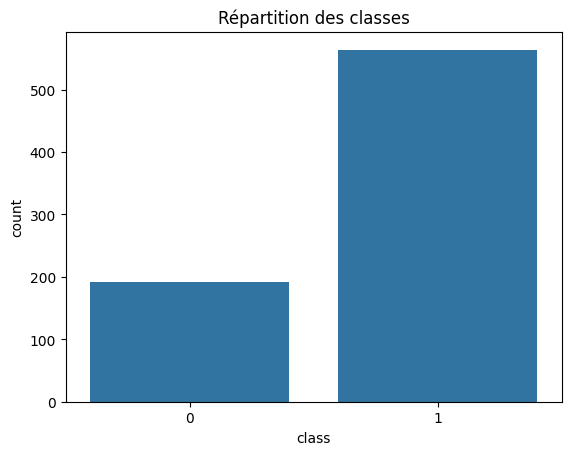

In [ ]:
# Visualisation de la répartition des classes
sns.countplot(x='class', data=data_cleaned)
plt.title("Répartition des classes")
plt.show()

##3. Préparation des Données

In [ ]:
X = data_cleaned.drop('class', axis=1)
y = data_cleaned['class']

In [ ]:
# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4. Sélection des meilleures caractéristiques avec SelectKBest et mutual_info_classif

In [ ]:

# Sélection des meilleures caractéristiques
selector = SelectKBest(mutual_info_classif, k='all')  # Sélectionner toutes les caractéristiques
X_train_selected = selector.fit_transform(X_train, y_train)  # Appliquer sur l'ensemble d'entraînement
X_test_selected = selector.transform(X_test)  # Appliquer sur l'ensemble de test


In [ ]:
# Affichage des scores des variables sélectionnées
print("Scores des variables sélectionnées:\n", selector.scores_)

Scores des variables sélectionnées:
 [0.0179223  0.00521038 0.04204554 0.02526803 0.08071163 0.08251513
 0.07020915 0.05164817 0.03859701 0.07685739 0.04848495 0.06991339
 0.06043108 0.03069973 0.04593797 0.0142996  0.02068104 0.05611878
 0.01236025 0.0194116  0.01048505 0.02105426 0.07725671 0.06111421
 0.06118114 0.03579309 0.01748683 0.02104165 0.         0.01237707
 0.         0.01309919 0.         0.04053963 0.04540733 0.
 0.0663453  0.0290119  0.00581467 0.01054404 0.00437578 0.
 0.03297501 0.00908649 0.0344068  0.         0.00526199 0.
 0.02903055 0.04065966 0.00794867 0.02587231 0.         0.03575368
 0.02245748 0.01529644 0.04591481 0.04911611 0.10093404 0.04439142
 0.01500759 0.03575621 0.04438735 0.00790843 0.02201278 0.01843616
 0.02174153 0.         0.03282263 0.02760657 0.03921478 0.
 0.041441   0.         0.02054427 0.         0.00875564 0.
 0.01125002 0.02181759 0.         0.02625827 0.01429564 0.03001343
 0.01440775 0.         0.         0.01370189 0.01439775 0.0086441

#5. Fonction pour Évaluer un Modèle

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{model.__class__.__name__}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    if hasattr(model, "predict_proba"):
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print("ROC AUC Score:", roc_auc)

In [ ]:
# Définition des modèles à évaluer
models = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    SVC(probability=True),
    RandomForestClassifier(),
    AdaBoostClassifier()
]

# Évaluation des modèles
for model in models:
    evaluate_model(model, X_train_selected, X_test_selected, y_train, y_test)



KNeighborsClassifier
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.61      0.75        38
           1       0.88      1.00      0.94       114

    accuracy                           0.90       152
   macro avg       0.94      0.80      0.85       152
weighted avg       0.91      0.90      0.89       152

Confusion Matrix:
 [[ 23  15]
 [  0 114]]
ROC AUC Score: 0.9203601108033241

DecisionTreeClassifier
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.58      0.58        38
           1       0.86      0.86      0.86       114

    accuracy                           0.79       152
   macro avg       0.72      0.72      0.72       152
weighted avg       0.79      0.79      0.79       152

Confusion Matrix:
 [[22 16]
 [16 98]]
ROC AUC Score: 0.7192982456140351

SVC
Classification Report:
               precision    recall  f1-score   support

           0       0

In [ ]:
# Validation croisée
print("\nValidation Croisée :")
for model in models:
    scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='accuracy')
    print(f"{model.__class__.__name__} - Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


Validation Croisée :
KNeighborsClassifier - Accuracy: 0.8295 ± 0.0143
DecisionTreeClassifier - Accuracy: 0.7930 ± 0.0094
SVC - Accuracy: 0.8444 ± 0.0328
RandomForestClassifier - Accuracy: 0.8510 ± 0.0278
AdaBoostClassifier - Accuracy: 0.8410 ± 0.0295


In [ ]:
# Importation des bibliothèques nécessaires
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, f1_score
)

# Résumé des résultats
results = []
for model in models:
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append({
        "Modèle": model.__class__.__name__,
        "Accuracy": accuracy,
        "F1-Score": f1
    })

results_df = pd.DataFrame(results)
print("\nRésumé des résultats :\n", results_df)



Résumé des résultats :
                    Modèle  Accuracy  F1-Score
0    KNeighborsClassifier  0.901316  0.892228
1  DecisionTreeClassifier  0.776316  0.778194
2                     SVC  0.861842  0.844130
3  RandomForestClassifier  0.861842  0.851314
4      AdaBoostClassifier  0.861842  0.859900


# 6. Modèle de Stacking

In [ ]:
# Implémentation du stacking
estimators = [
    ('knn', KNeighborsClassifier()),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('svc', SVC(probability=True))
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=AdaBoostClassifier())
evaluate_model(stacking_model, X_train_selected, X_test_selected, y_train, y_test)



StackingClassifier
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.76      0.73        38
           1       0.92      0.89      0.91       114

    accuracy                           0.86       152
   macro avg       0.81      0.83      0.82       152
weighted avg       0.87      0.86      0.86       152

Confusion Matrix:
 [[ 29   9]
 [ 12 102]]
ROC AUC Score: 0.9058171745152354


# 7. Sélection de variables par un modèle de type GradientBoosting

In [ ]:
# Sélection de variables basée sur un modèle d'ensemble (GradientBoosting)
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [ ]:
# Sélection des variables les plus importantes
select_model = SelectFromModel(gb_model, threshold="mean", max_features=10)
X_train_selected_model = select_model.transform(X_train)
X_test_selected_model = select_model.transform(X_test)

In [ ]:
# Évaluation avec le modèle après sélection des variables
evaluate_model(gb_model, X_train_selected_model, X_test_selected_model, y_train, y_test)


GradientBoostingClassifier
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.66      0.69        38
           1       0.89      0.92      0.91       114

    accuracy                           0.86       152
   macro avg       0.81      0.79      0.80       152
weighted avg       0.85      0.86      0.85       152

Confusion Matrix:
 [[ 25  13]
 [  9 105]]
ROC AUC Score: 0.8988919667590027
